In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.draw
from pathlib import Path
from IPython import display
from scipy.spatial import cKDTree
from PIL import Image, ImageDraw, ImageColor
from abc import ABCMeta, abstractmethod

import shapely
from shapely.ops import triangulate
from shapely.geometry import box, Point, LineString, Polygon, MultiPoint, MultiPolygon, asMultiPoint

import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl

### The 3-part Lowpolyfication System

- **Point Generation**: Given an image, generate a set of points
- **Polygon Generation**: Given an image and a set of points, generate a set of polygons
- **Shading**: Given an image and a set of polygons, shade the image to get a low-poly image

The cell below defines the base classes for each of these components

In [3]:
class PointGenerator(metaclass=ABCMeta):
    """
    Takes in a PIL image and returns a list of normalized shapely points
    """
    @abstractmethod
    def call(self, image, *args, **kwargs):
        pass

    def __call__(self, image, *args, **kwargs):
        points = self.call(image, *args, **kwargs)
        points = self.rescale_points(points, image.size)
        points = self.remove_duplicates(points, 4)
        points = self.with_boundary_points(points, image.size)
        return points

    @staticmethod
    def rescale_points(points, image_size):
        """
        Rescales [0, 1] normalized points to the specified Width x Height.
        """
#         return [shapely.affinity.scale(p, *size, origin=(0, 0)) for p in points]
        coordinates = (np.array([p.xy for p in points]).squeeze(-1) * image_size).round()
        return list(asMultiPoint(coordinates))

    @staticmethod
    def with_boundary_points(points, image_size):
        edge_box = box(0, 0, *image_size)
        edges = edge_box.exterior

#         hull = shapely.ops.unary_union(points).convex_hull
#         hull_points = [Point(c) for c in hull.exterior.coords]
#         edge_points = [edges.interpolate(edges.project(p)) for p in hull_points]
        edge_points = []

        corners = [Point(c) for c in edges.coords[:-1]]

        return points + edge_points + corners

    @staticmethod
    def remove_duplicates(points, tolerance):
        coordinates = np.array([p.xy for p in points]).squeeze(-1)

        tree = cKDTree(coordinates, compact_nodes=len(points) > 1000)
        close_pairs = tree.query_pairs(r=tolerance, output_type="ndarray")

        unsafe_indices = np.unique(close_pairs)
        safe_indices = np.ones(len(points), dtype=np.bool)
        safe_indices[unsafe_indices] = 0
        safe_coordinates = coordinates[safe_indices]
#         print("Total", len(points))
#         print("Unsafe", len(unsafe_indices))
#         print("Safe", len(safe_coordinates))

        neighbors = {}
        for i, j in close_pairs:
            neighbors.setdefault(i, set()).add(j)
            neighbors.setdefault(j, set()).add(i)
        discard = set()
        keep = []
        for node in range(len(points)):
            if node not in discard:
                keep.append(node)
                discard.update(neighbors.get(node, set()))
        points = [p for i, p in enumerate(points) if i not in discard]
        return points


class Polygonizer(metaclass=ABCMeta):
    """
    Takes in a PIL Image and (optionally) a list of shapely points and returns a list of shapely polygons.
    Output should be independent of the order of points.
    """
    @abstractmethod
    def call(self, image, points, *args, **kwargs):
        pass

    def __call__(self, image, points, *args, **kwargs):
        polygons = self.call(image, points, *args, **kwargs)
        polygons = self.simplify(polygons)
        return polygons

    @staticmethod
    def simplify(polygons):
        # TODO: Merge small polygons
        return polygons


class Shader(metaclass=ABCMeta):
    """
    Takes in a PIL image and (optionally) a list of points and (optionally) a list of polygons and returns a shaded image.
    Output should be independent of the order of points or polygons.
    """
    @abstractmethod
    def call(self, image, points, polygons, *args, **kwargs):
        pass

    def __call__(self, image, points, polygons, *args, **kwargs):
        return self.call(image, points, polygons, *args, **kwargs)

In [6]:
class RandomPoints(PointGenerator):
    def __init__(self, num_points=50):
        self.num_points = num_points

    def call(self, image):
        coordinates = np.random.rand(self.num_points, len(image.size))
        points = [Point(c) for c in coordinates]
        return points


class DelaunayTriangulator(Polygonizer):
    def call(self, image, points):
        if not isinstance(points, MultiPoint):
            points = MultiPoint(points)
        triangles = triangulate(points)
        return triangles


class MeanShader(Shader):
    def call(self, image, points, polygons):
        image = np.array(image)
        shaded = np.array(image)
        mask = np.zeros((*image.shape[:2], 1), dtype=np.uint8)
        for polygon in polygons:
            coords = np.array(polygon.exterior.coords)

            mask[:] = 0
            cv2.fillPoly(mask, [(coords * 256).astype(np.int32)], 255, shift=8)
            mean_color = np.array(cv2.mean(image, mask=mask)[:3], dtype=np.uint8)
            cv2.fillPoly(shaded, [(coords * 256).astype(int)], mean_color.tolist(), lineType=cv2.LINE_AA, shift=8)

            # TODO: Remove this once polygon merging code is done
            rr, cc = skimage.draw.polygon(*coords.T[::-1])
            region = image[rr, cc]
            if region.size == 0:
#                 print("Too small:", polygon)
                continue
        return Image.fromarray(shaded)


class KmeansShader(Shader):
    def __init__(self, num_clusters=3, num_attempts=3):
        self.num_clusters = num_clusters
        self.num_attempts = num_attempts

    @staticmethod
    def get_dominant_color(pixels, clusters, attempts):
        """
        Given a (N, Channels) array of pixel values, compute the dominant color via K-means
        """
        clusters = min(clusters, len(pixels))
        flags = cv2.KMEANS_RANDOM_CENTERS
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, 1, 10)
        _, labels, centroids = cv2.kmeans(pixels.astype(np.float32), clusters, None, criteria, attempts, flags)
        _, counts = np.unique(labels, return_counts=True)
        dominant = centroids[np.argmax(counts)]
        return dominant

    def call(self, image, points, polygons):
        image = np.array(image)
        shaded = np.zeros_like(image)
        for polygon in polygons:
            coords = np.array(polygon.exterior.coords)
            rr, cc = skimage.draw.polygon(*coords.T[::-1])
            region = image[rr, cc]

            if len(region) == 0:
                continue

            mean_color = self.get_dominant_color(region, self.num_clusters, self.num_attempts)
            cv2.fillPoly(shaded, [(coords * 256).astype(int)], mean_color.tolist(), lineType=cv2.LINE_AA, shift=8)
        return Image.fromarray(shaded)

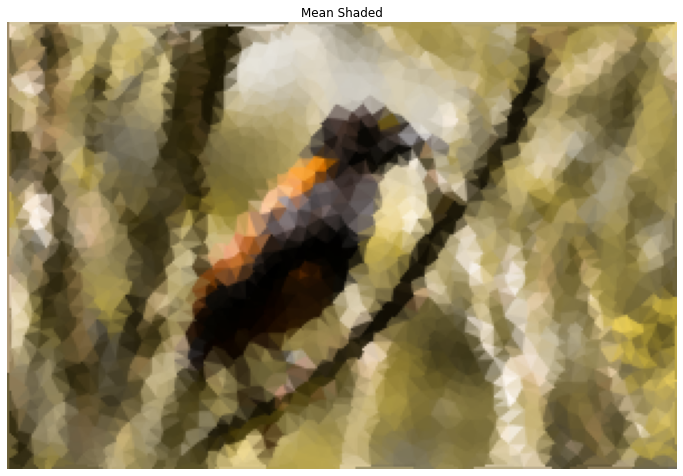

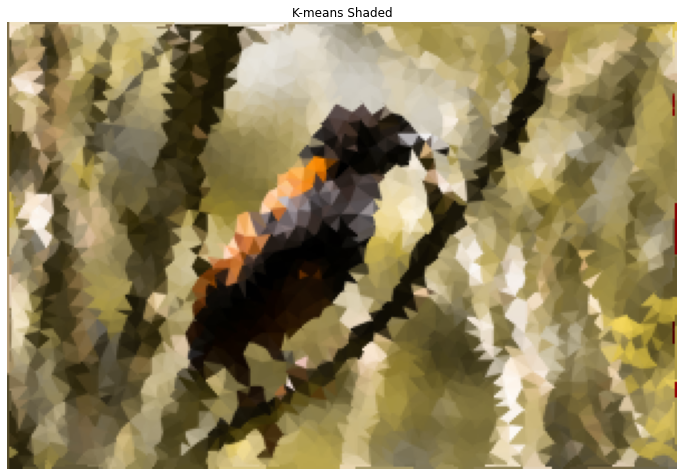

         1744696 function calls (1730265 primitive calls) in 2.277 seconds

   Ordered by: internal time
   List reduced from 1318 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.268    0.134    0.268    0.134 {built-in method matplotlib._png.write_png}
      240    0.142    0.001    0.142    0.001 {method 'decode' of 'ImagingDecoder' objects}
     3848    0.135    0.000    0.135    0.000 {mean}
     7696    0.115    0.000    0.243    0.000 {skimage.draw._draw._polygon}
    55915    0.101    0.000    0.214    0.000 {built-in method numpy.array}
    31506    0.091    0.000    0.091    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.088    0.088    0.533    0.533 <ipython-input-6-9bddf9df2593>:20(call)
    21947    0.079    0.000    0.089    0.000 point.py:196(geos_point_from_py)
        1    0.072    0.072    0.603    0.603 <ipython-input-6-9bddf9df2593>:58(call)
        1    0.072    0.072    0.204   

In [7]:
%%prun -l 30
IMAGE_PATH = "../images/bird1.jpg"
image = Image.open(IMAGE_PATH)
image.thumbnail((300, 300))
# plt.figure(figsize=(8, 8))
# plt.title("Original")
# plt.imshow(image)
# plt.axis("off")
# plt.show()

points = RandomPoints(10000)(image)
polygons = DelaunayTriangulator()(image, points)

shaded = MeanShader()(image, points, polygons)
plt.figure(figsize=(12, 12))
plt.title("Mean Shaded")
plt.imshow(shaded)
plt.axis("off")
plt.show()

shaded = KmeansShader()(image, points, polygons)
plt.figure(figsize=(12, 12))
plt.title("K-means Shaded")
plt.imshow(shaded)
plt.axis("off")
plt.show()

In [ ]:
class Model(pl.LightningModule):
    def __init__(self):
        self.transform = transforms.Compose([
            #     transforms.Resize(400),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def forward(self, x):
        pass

    def training_step(self, batch, batch_idx):
        pass

    def configure_optimizer(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)